# 🛠 Exercises

## 0. Prerequisites

In [5]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds

In [6]:
# Get data
(train_data, test_data), ds_info = tfds.load(name='food101',
                                             split=['train', 'validation'],
                                             shuffle_files=True,
                                             as_supervised=True,
                                             with_info=True)

In [7]:
# Check info
ds_info

tfds.core.DatasetInfo(
    name='food101',
    full_name='food101/2.0.0',
    description="""
    This dataset consists of 101 food categories, with 101'000 images. For each class, 250 manually reviewed test images are provided as well as 750 training images. On purpose, the training images were not cleaned, and thus still contain some amount of noise. This comes mostly in the form of intense colors and sometimes wrong labels. All images were rescaled to have a maximum side length of 512 pixels.
    """,
    homepage='https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/',
    data_dir='/root/tensorflow_datasets/food101/2.0.0',
    file_format=tfrecord,
    download_size=4.65 GiB,
    dataset_size=4.77 GiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=101),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'train': <SplitInfo nu

In [9]:
# Get class names
class_names = ds_info.features['label'].names

In [24]:
# Preprocessing function
def preprocess_img(image, label):
    image = tf.image.resize(image, [224, 224])
    return tf.cast(image, dtype=tf.float32), label

In [25]:
# Preprocess train data
train_data_prep = train_data.map(map_func=preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)
train_data_prep = train_data_prep.shuffle(buffer_size=1000).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)

# Preprocess test data
test_data_prep = test_data.map(map_func=preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)
test_data_prep = test_data_prep.batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)

train_data_prep, test_data_prep

(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>)

In [26]:
# Download and unzip model
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/07_efficientnetb0_fine_tuned_101_classes_mixed_precision.zip
!unzip 07_efficientnetb0_fine_tuned_101_classes_mixed_precision.zip

--2023-12-16 12:59:22--  https://storage.googleapis.com/ztm_tf_course/food_vision/07_efficientnetb0_fine_tuned_101_classes_mixed_precision.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.20.207, 74.125.197.207, 74.125.135.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.20.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 46790356 (45M) [application/zip]
Saving to: ‘07_efficientnetb0_fine_tuned_101_classes_mixed_precision.zip’

07_efficientnetb0_f 100%[===================>]  44.62M  69.5MB/s    in 0.6s    

2023-12-16 12:59:23 (69.5 MB/s) - ‘07_efficientnetb0_fine_tuned_101_classes_mixed_precision.zip’ saved [46790356/46790356]

Archive:  07_efficientnetb0_fine_tuned_101_classes_mixed_precision.zip
   creating: 07_efficientnetb0_fine_tuned_101_classes_mixed_precision/
   creating: 07_efficientnetb0_fine_tuned_101_classes_mixed_precision/variables/
  inflating: 07_efficientnetb0_fine_tuned_101_classes_mixed

In [27]:
# Load model
model = tf.keras.models.load_model("07_efficientnetb0_fine_tuned_101_classes_mixed_precision")

In [28]:
# Check the model summary
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional  (None, None, None, 1280   4049571   
 )                           )                                   
                                                                 
 pooling_layer (GlobalAvera  (None, 1280)              0         
 gePooling2D)                                                    
                                                                 
 dense (Dense)               (None, 101)               129381    
                                                                 
 softmax_float32 (Activatio  (None, 101)               0         
 n)                                                              
                                                             

## 1. Use the same evaluation techniques on the large-scale Food Vision model as you did in the previous notebook ([Transfer Learning Part 3: Scaling up](https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/06_transfer_learning_in_tensorflow_part_3_scaling_up.ipynb)). More specifically, it would be good to see:
- A confusion matrix between all of the model's predictions and true labels.
- A graph showing the f1-scores of each class.
- A visualization of the model making predictions on various images and comparing the predictions to the ground truth.
    - For example, plot a sample image from the test dataset and have the title of the plot showing the prediction, the prediction probability, and the ground truth label.

In [40]:
# Evaluate a model
model.evaluate(test_data_prep)

790/790 [==============================] - 54s 66ms/step - loss: 0.9072 - accuracy: 0.8015


[0.9072173833847046, 0.8014653325080872]

In [43]:
# Get labels and predictions
y_pred = model.predict(test_data_prep).argmax(axis = 1)
y_true = [y.numpy() for x, y in test_data_prep.unbatch()]

790/790 [==============================] - 50s 63ms/step


array([83,  1, 45, ..., 41, 70, 31])

In [30]:
# Note: The following confusion matrix code is a remix of Scikit-Learn's
# plot_confusion_matrix function - https://scikit-learn.org/stable/modules/generated/sklearn.metrics.plot_confusion_matrix.html
import itertools
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

# Our function needs a different name to sklearn's plot_confusion_matrix
def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15, norm=False, savefig=False):
    """Makes a labelled confusion matrix comparing predictions and ground truth labels.

    If classes is passed, confusion matrix will be labelled, if not, integer class values
    will be used.

    Args:
        y_true: Array of truth labels (must be same shape as y_pred).
        y_pred: Array of predicted labels (must be same shape as y_true).
        classes: Array of class labels (e.g. string form). If `None`, integer labels are used.
        figsize: Size of output figure (default=(10, 10)).
        text_size: Size of output figure text (default=15).
        norm: normalize values or not (default=False).
        savefig: save confusion matrix to file (default=False).

    Returns:
        A labelled confusion matrix plot comparing y_true and y_pred.

    Example usage:
        make_confusion_matrix(y_true=test_labels,   # ground truth test labels
                              y_pred=y_preds,       # predicted labels
                              classes=class_names,  # array of class label names
                              figsize=(15, 15),
                              text_size=10)
    """
    # Create the confustion matrix
    cm = confusion_matrix(y_true, y_pred)
    cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]    # normalize it
    n_classes = cm.shape[0]                                         # find the number of classes we're dealing with

    # Plot the figure and make it pretty
    fig, ax = plt.subplots(figsize=figsize)
    cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
    fig.colorbar(cax)

    # Are there a list of classes?
    if classes:
        labels = classes
    else:
        labels = np.arange(cm.shape[0])

    # Label the axes
    ax.set(title="Confusion Matrix",
           xlabel="Predicted label",
           ylabel="True label",
           xticks=np.arange(n_classes), # create enough axis slots for each class
           yticks=np.arange(n_classes),
           xticklabels=labels,          # axes will labeled with class names (if they exist) or ints
           yticklabels=labels)

    # Make x-axis labels appear on bottom
    ax.xaxis.set_label_position("bottom")
    ax.xaxis.tick_bottom()

    ### Added: Rotate xticks for readability & increase font size (required due to such a large confusion matrix)
    plt.xticks(rotation=70, fontsize=text_size)
    plt.yticks(fontsize=text_size)

    # Set the threshold for different colors
    threshold = (cm.max() + cm.min()) / 2.

    # Plot the text on each cell
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if norm:
            plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
                    horizontalalignment="center",
                    color="white" if cm[i, j] > threshold else "black",
                    size=text_size)
        else:
            plt.text(j, i, f"{cm[i, j]}",
                    horizontalalignment="center",
                    color="white" if cm[i, j] > threshold else "black",
                    size=text_size)

    # Save the figure to the current working directory
    if savefig:
        fig.savefig("confusion_matrix.png")

In [76]:
make_confusion_matrix(y_true=y_true,
                      y_pred=y_pred,
                      classes=class_names,
                      figsize=(100, 100),
                      text_size=20)

Output hidden; open in https://colab.research.google.com to view.

In [77]:
# F1-scores of each class
from sklearn.metrics import classification_report

report_dict = classification_report(y_true, y_pred, output_dict = True)
report_dict

{'0': {'precision': 0.01606425702811245,
  'recall': 0.016,
  'f1-score': 0.01603206412825651,
  'support': 250},
 '1': {'precision': 0.016736401673640166,
  'recall': 0.016,
  'f1-score': 0.016359918200408996,
  'support': 250},
 '2': {'precision': 0.007874015748031496,
  'recall': 0.008,
  'f1-score': 0.007936507936507936,
  'support': 250},
 '3': {'precision': 0.01556420233463035,
  'recall': 0.016,
  'f1-score': 0.015779092702169626,
  'support': 250},
 '4': {'precision': 0.01556420233463035,
  'recall': 0.016,
  'f1-score': 0.015779092702169626,
  'support': 250},
 '5': {'precision': 0.013215859030837005,
  'recall': 0.012,
  'f1-score': 0.012578616352201257,
  'support': 250},
 '6': {'precision': 0.0125,
  'recall': 0.012,
  'f1-score': 0.012244897959183675,
  'support': 250},
 '7': {'precision': 0.015810276679841896,
  'recall': 0.016,
  'f1-score': 0.015904572564612324,
  'support': 250},
 '8': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 250},
 '9': {'precisio

In [78]:
# Create an empty dictionary
f1_scores = {}

# For-loop to retrieve f1-scores
for k, v in report_dict.items():
    if k == 'accuracy':
        break
    else:
        f1_scores[class_names[int(k)]] = v["f1-score"]
f1_scores

{'apple_pie': 0.01603206412825651,
 'baby_back_ribs': 0.016359918200408996,
 'baklava': 0.007936507936507936,
 'beef_carpaccio': 0.015779092702169626,
 'beef_tartare': 0.015779092702169626,
 'beet_salad': 0.012578616352201257,
 'beignets': 0.012244897959183675,
 'bibimbap': 0.015904572564612324,
 'bread_pudding': 0.0,
 'breakfast_burrito': 0.012820512820512822,
 'bruschetta': 0.00851063829787234,
 'caesar_salad': 0.00398406374501992,
 'cannoli': 0.00814663951120163,
 'caprese_salad': 0.0186219739292365,
 'carrot_cake': 0.011627906976744186,
 'ceviche': 0.007984031936127744,
 'cheesecake': 0.011741682974559688,
 'cheese_plate': 0.011811023622047244,
 'chicken_curry': 0.0038986354775828462,
 'chicken_quesadilla': 0.0040650406504065045,
 'chicken_wings': 0.004081632653061225,
 'chocolate_cake': 0.011952191235059759,
 'chocolate_mousse': 0.022684310018903593,
 'churros': 0.012072434607645876,
 'clam_chowder': 0.004048582995951417,
 'club_sandwich': 0.011583011583011582,
 'crab_cakes': 0.00

In [79]:
# Dict to data frame
df_f1_scores = pd.DataFrame({"class_name": f1_scores.keys(),
                             "f1-score": f1_scores.values()}).sort_values("f1-score", ascending=False)
df_f1_scores

,class_name,f1-score
96,tacos,0.027132
48,greek_salad,0.023576
22,chocolate_mousse,0.022684
81,ramen,0.020877
47,gnocchi,0.020284
...,...,...
8,bread_pudding,0.000000
43,fried_calamari,0.000000
76,pizza,0.000000
74,peking_duck,0.000000


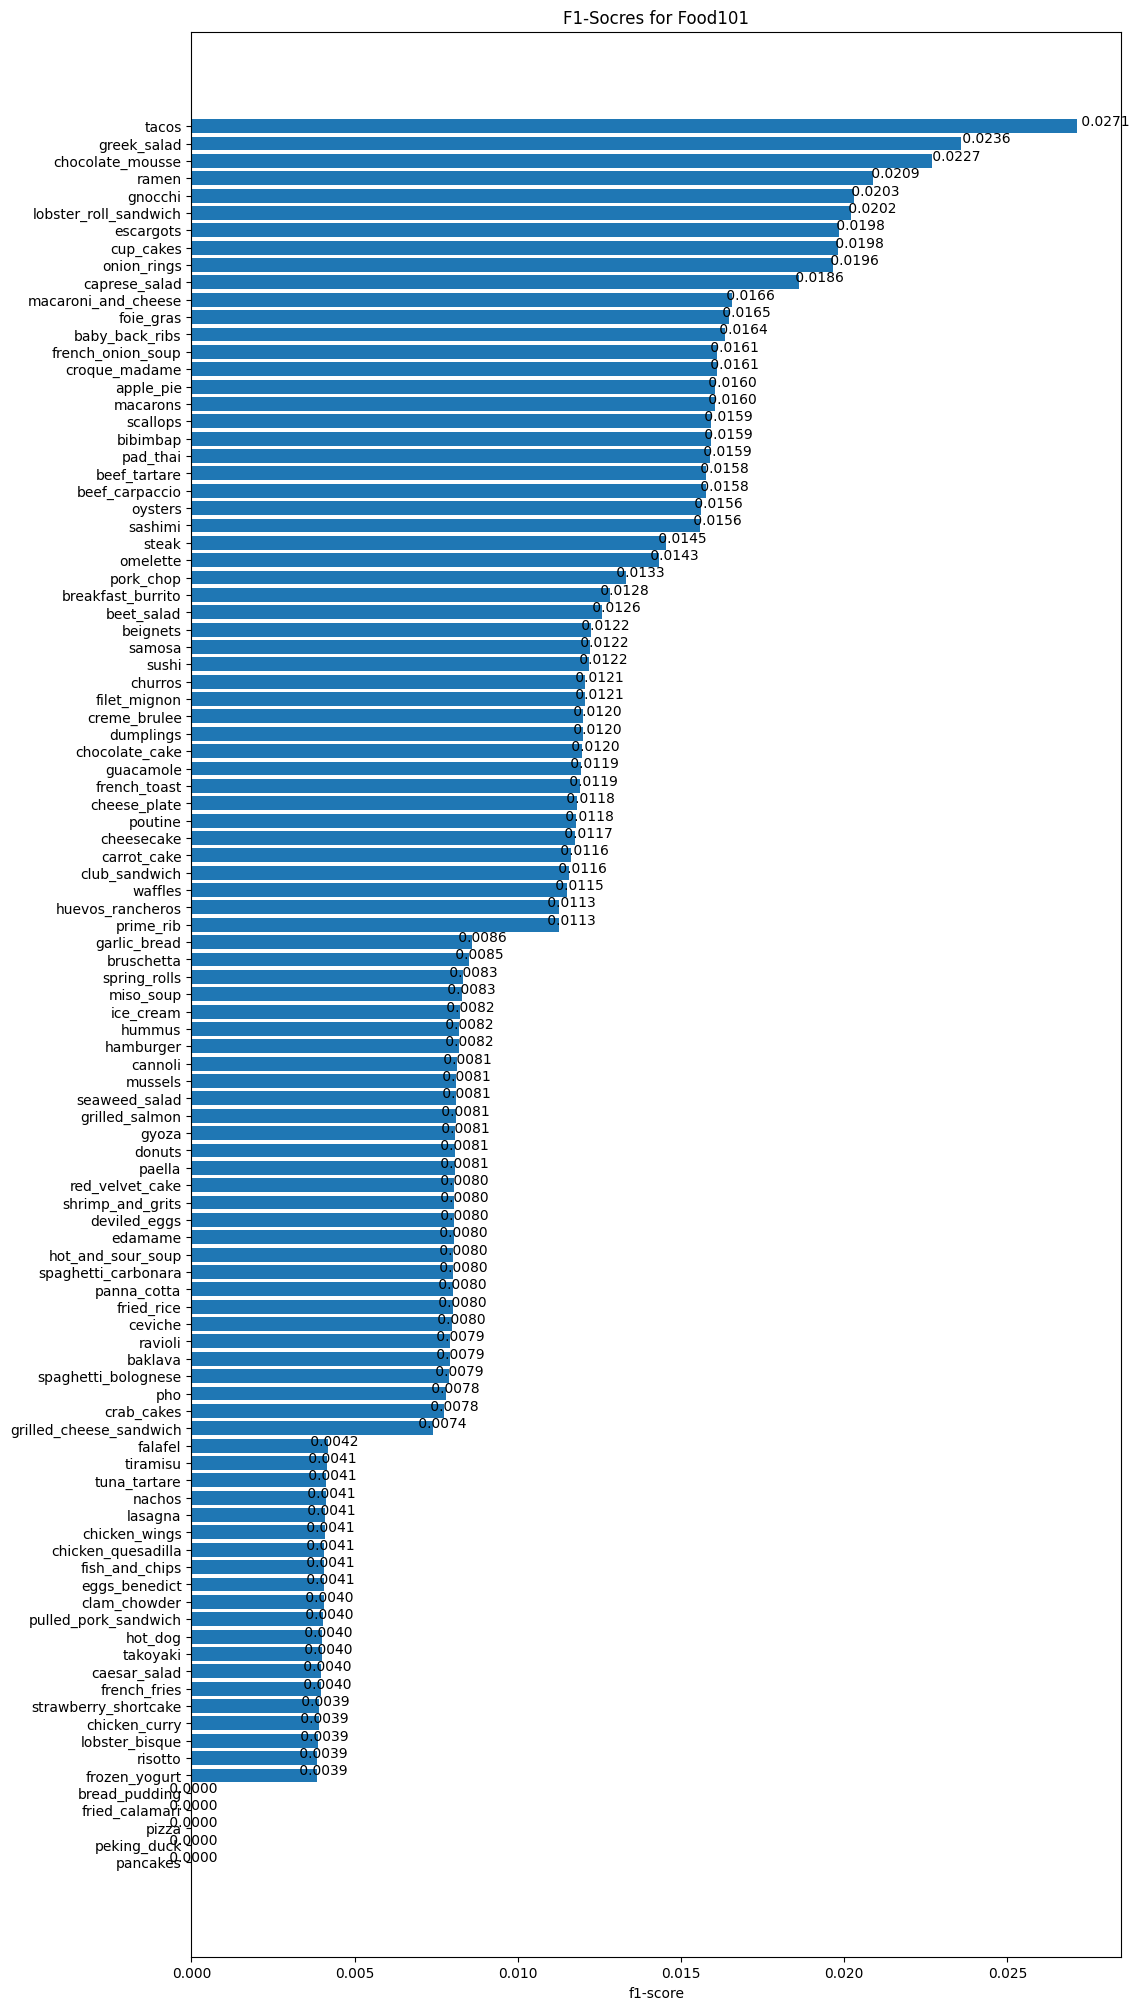

In [81]:
# Plot f1-scores
fig, ax = plt.subplots(figsize=(12, 25))
scores = ax.barh(range(len(df_f1_scores)), df_f1_scores['f1-score'].values)
ax.set_yticks(range(len(df_f1_scores)))
ax.set_yticklabels(df_f1_scores['class_name'])
ax.set_xlabel('f1-score')
ax.set_title("F1-Socres for Food101")
ax.invert_yaxis();

def autolabel(rects):
    for rect in rects:
        width = rect.get_width()
        ax.text(1.03 * width, rect.get_y() + rect.get_height() / 1.5,
                f"{width: .4f}",
                ha='center', va='bottom')

autolabel(scores)

In [57]:
# Get random samples from the test data
random_data = tf.data.Dataset.sample_from_datasets([test_data_prep.unbatch()])
random_data

<_UnbatchDataset element_spec=(TensorSpec(shape=(224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

1/1 [==============================] - 0s 50ms/step


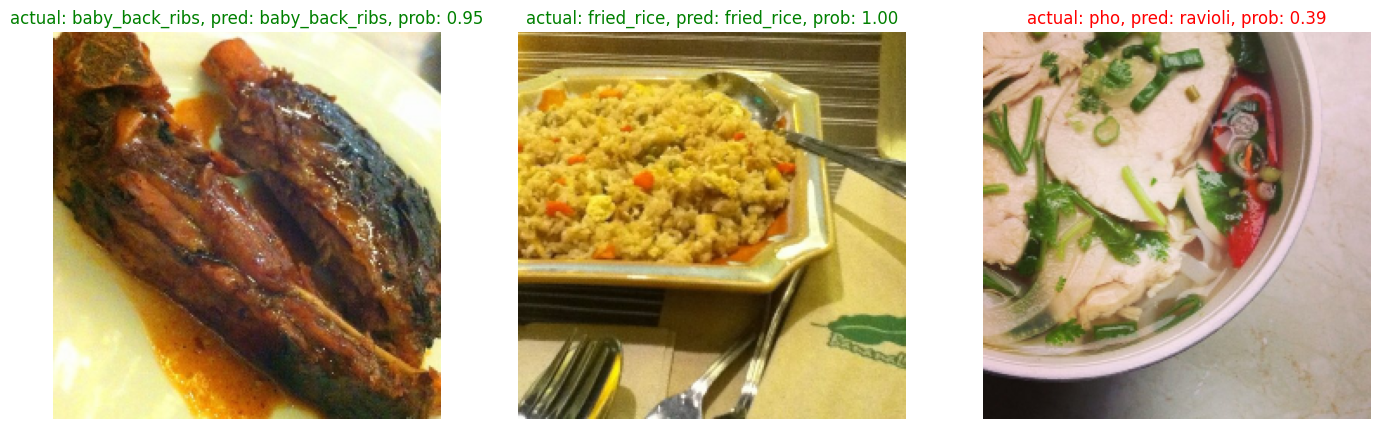

In [62]:
# Plot 3 random samples
plt.figure(figsize=(17, 10))
for i, (image, label) in enumerate(random_data.take(3)):
    class_name = class_names[label]
    pred_prob = model.predict(tf.expand_dims(image, axis = 0))
    pred_class = class_names[pred_prob.argmax()]

    plt.subplot(1, 3, i + 1)
    plt.imshow(image / 255)
    if class_name == pred_class:
        title_color = "g"
    else:
        title_color = "r"
    plt.title(f"actual: {class_name}, pred: {pred_class}, prob: {pred_prob.max():.2f}", c=title_color)
    plt.axis(False);

## 2. Take 3 of your photos of food and use the Food Vision model to make predictions on them. How does it go? Share your images/predictions with the other students.

In [63]:
# Get 3 custom photos
!wget -O "steak.jpeg" "https://images.unsplash.com/photo-1504674900247-0877df9cc836?q=80&w=2070&auto=format&fit=crop&ixlib=rb-4.0.3&ixid=M3wxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8fA%3D%3D"
!wget -O "pizza.jpeg" "https://images.unsplash.com/photo-1571066811602-716837d681de?q=80&w=1844&auto=format&fit=crop&ixlib=rb-4.0.3&ixid=M3wxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8fA%3D%3D"
!wget -O "pancake.jpeg" "https://images.unsplash.com/photo-1567620905732-2d1ec7ab7445?q=80&w=1980&auto=format&fit=crop&ixlib=rb-4.0.3&ixid=M3wxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8fA%3D%3D"

--2023-12-16 13:47:03--  https://images.unsplash.com/photo-1504674900247-0877df9cc836?q=80&w=2070&auto=format&fit=crop&ixlib=rb-4.0.3&ixid=M3wxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8fA%3D%3D
Resolving images.unsplash.com (images.unsplash.com)... 151.101.22.208, 2a04:4e42:5::720
Connecting to images.unsplash.com (images.unsplash.com)|151.101.22.208|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 787595 (769K) [image/jpeg]
Saving to: ‘steak.jpeg’

steak.jpeg          100%[===================>] 769.14K  --.-KB/s    in 0.03s   

2023-12-16 13:47:04 (21.6 MB/s) - ‘steak.jpeg’ saved [787595/787595]

--2023-12-16 13:47:04--  https://images.unsplash.com/photo-1571066811602-716837d681de?q=80&w=1844&auto=format&fit=crop&ixlib=rb-4.0.3&ixid=M3wxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8fA%3D%3D
Resolving images.unsplash.com (images.unsplash.com)... 151.101.22.208, 2a04:4e42:5::720
Connecting to images.unsplash.com (images.unsplash.com)|151.101.22.208|:443... connected.
HT

In [71]:
# Get image paths
import glob

filepaths = [img_f[2:] for img_f in glob.glob("./*.jpeg")]
filepaths

['pizza.jpeg', 'pancake.jpeg', 'steak.jpeg']

In [67]:
# preparing and loading image function
def load_and_prep_image(filename, img_shape=224, scale=False):
    img = tf.io.read_file(filename)
    img = tf.io.decode_image(img)
    img = tf.image.resize(img, size = [img_shape, img_shape])

    if scale:
        return img / 255
    else:
        return img

1/1 [==============================] - 0s 30ms/step


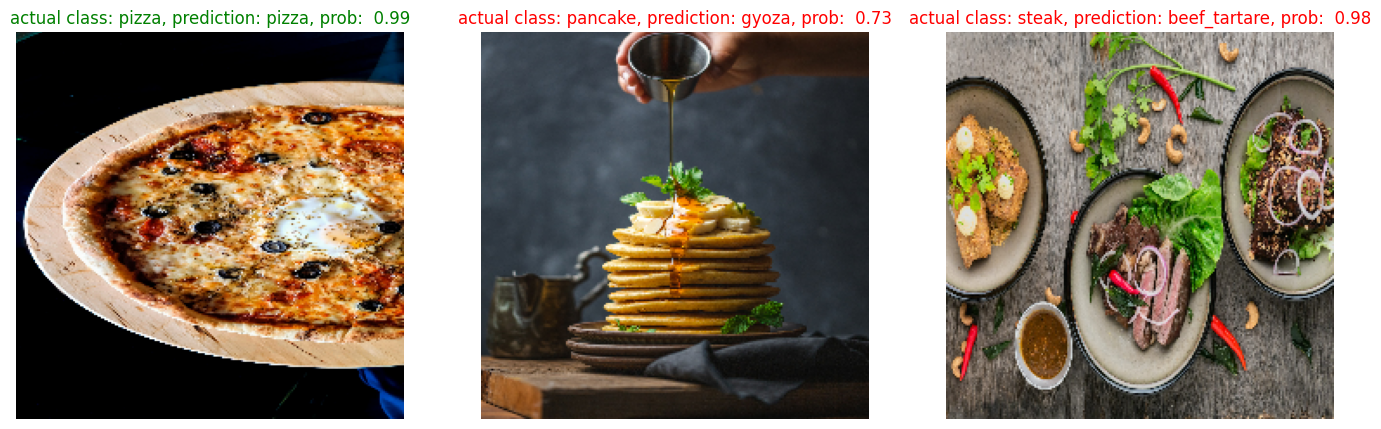

In [72]:
# Predict and plot custom images
plt.figure(figsize=(17, 10))
for i in range(len(filepaths)):
    class_name = filepaths[i].split('.')[0]
    img = load_and_prep_image(filepaths[i], scale = False)
    pred_prob = model.predict(tf.expand_dims(img, axis = 0))
    pred_class = class_names[pred_prob.argmax()]

    plt.subplot(1, 3, i + 1)
    plt.imshow(img / 255)
    if class_name == pred_class:
        plt.title(f"actual class: {class_name}, prediction: {pred_class}, prob: {pred_prob.max(): .2f}", c="g")
    else:
        plt.title(f"actual class: {class_name}, prediction: {pred_class}, prob: {pred_prob.max(): .2f}", c="r")
    plt.axis(False)

## 3. Retrain the model (feature extraction and fine-tuning) we trained in this chapter, except this time use [`EfficientNetB4`](https://www.tensorflow.org/api_docs/python/tf/keras/applications/EfficientNetB4) as the base model instead of `EfficientNetB0`. Do you notice a performance improvement? Does it take longer to train? Are there any tradeoffs to consider?

In [86]:
# Set mixed precision
from tensorflow.keras import mixed_precision

mixed_precision.set_global_policy(policy = "mixed_float16")

In [88]:
# Load EfficientNetB4 model
base_model = tf.keras.applications.efficientnet.EfficientNetB4(include_top = False)
base_model.trainable = False

# Build a model
inputs = tf.keras.Input(shape = (224, 224, 3))
x = base_model(inputs, training = False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(len(class_names))(x)
outputs = tf.keras.layers.Activation('softmax', dtype = tf.float32)(x)
model_3 = tf.keras.Model(inputs = inputs, outputs = outputs)

In [89]:
# Model summary
model_3.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb4 (Functional  (None, None, None, 1792   17673823  
 )                           )                                   
                                                                 
 global_average_pooling2d_2  (None, 1792)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_2 (Dense)             (None, 101)               181093    
                                                                 
 activation (Activation)     (None, 101)               0         
                                                                 
Total params: 17854916 (68.11 MB)
Trainable params: 181093 (7

In [ ]:
# Create callbacks
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                      patience=2,
                                      verbose=1)

checkpoint_path = "model_checkpoints/cp.ckpt"
mckpt = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                           monitor='val_loss',
                                           verbose=1,
                                           save_best_only=True,
                                           save_weights_only=True)

log_dir = model_3.layers[1].name + "food101_all"
tb = tf.keras.callbacks.TensorBoard(log_dir = log_dir)

## 4. Name one important benefit of mixed precision training, how does this benefit take place?

Mixed precision training allows the model to be trained faster without hurting the performance.

# 📖 Extra-curriculum
- Read up on learning rate scheduling and the [learning rate scheduler callback](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/LearningRateScheduler). What is it? And how might it be helpful to this project?
- Read up on TensorFlow data loaders ([improving TensorFlow data loading performance](https://www.tensorflow.org/guide/data_performance)). Is there anything we've missed? What methods do you keep in mind whenever loading data in TensorFlow? Hint: check the summary at the bottom of the page for a great round-up of ideas.
- Read up on the documentation for [TensorFlow mixed precision training](https://www.tensorflow.org/guide/mixed_precision). What are the important things to keep in mind when using mixed precision training?